In [18]:
import numpy as np 
import pandas as pd
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from collections import Counter
import cv2
import imutils

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Embedding, Conv1D, GlobalMaxPooling1D, Flatten, Dropout, Input, Lambda, concatenate, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, SGD, Adamax
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.applications import imagenet_utils

from tensorflow.python.keras.applications.vgg16 import VGG16, preprocess_input
# from tensorflow.python.keras.applications.resnet import ResNet50, preprocess_input 
from tensorflow.python.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input 
# from tensorflow.python.keras.applications.efficientnet import EfficientNetB6, preprocess_input 


from tensorflow.python.framework.ops import disable_eager_execution, enable_eager_execution
#disable_eager_execution()


In [19]:
#@title Cam Class
####
class GradCAM:
  def __init__(self, model, classIdx, layerName=None):
    # store the model, the class index used to measure the class
    # activation map, and the layer to be used when visualizing
    # the class activation map
    self.model = model
    self.classIdx = classIdx
    self.layerName = layerName
    # if the layer name is None, attempt to automatically find
    # the target output layer
    if self.layerName is None:
      self.layerName = self.find_target_layer()
   
  def find_target_layer(self):
    # attempt to find the final convolutional layer in the network
    # by looping over the layers of the network in reverse order
    for layer in reversed(self.model.layers):
      # check to see if the layer has a 4D output
      if len(layer.output_shape) == 4:
        return layer.name
    # otherwise, we could not find a 4D layer so the GradCAM
    # algorithm cannot be applied
    raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")
  
  def compute_heatmap(self, image, eps=1e-8):
    # construct our gradient model by supplying (1) the inputs
    # to our pre-trained model, (2) the output of the (presumably)
    # final 4D layer in the network, and (3) the output of the
    # softmax activations from the model
    gradModel = Model(
      inputs=[self.model.inputs],
      outputs=[self.model.get_layer(self.layerName).output,
        self.model.output])
  
  	# record operations for automatic differentiation
    with tf.GradientTape() as tape:
      # cast the image tensor to a float-32 data type, pass the
      # image through the gradient model, and grab the loss
      # associated with the specific class index
      inputs = tf.cast(image, tf.float32)
      (convOutputs, predictions) = gradModel(inputs)
      loss = predictions[:, self.classIdx]
      # use automatic differentiation to compute the gradients
      grads = tape.gradient(loss, convOutputs)

    # compute the guided gradients
    castConvOutputs = tf.cast(convOutputs > 0, "float32")
    castGrads = tf.cast(grads > 0, "float32")
    guidedGrads = castConvOutputs * castGrads * grads
    # the convolution and guided gradients have a batch dimension
    # (which we don't need) so let's grab the volume itself and
    # discard the batch
    convOutputs = convOutputs[0]
    guidedGrads = guidedGrads[0]

    # compute the average of the gradient values, and using them
    # as weights, compute the ponderation of the filters with
    # respect to the weights
    weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
    cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)
  
    # grab the spatial dimensions of the input image and resize
    # the output class activation map to match the input image
    # dimensions
    (w, h) = (image.shape[2], image.shape[1])
    heatmap = cv2.resize(cam.numpy(), (w, h))
    # normalize the heatmap such that all values lie in the range
    # [0, 1], scale the resulting values to the range [0, 255],
    # and then convert to an unsigned 8-bit integer
    numer = heatmap - np.min(heatmap)
    denom = (heatmap.max() - heatmap.min()) + eps
    heatmap = numer / denom
    heatmap = (heatmap * 255).astype("uint8")
    # return the resulting heatmap to the calling function
    return heatmap

  def overlay_heatmap(self, heatmap, image, alpha=0.5,
    colormap=cv2.COLORMAP_VIRIDIS):
    # apply the supplied color map to the heatmap and then
    # overlay the heatmap on the input image
    heatmap = cv2.applyColorMap(heatmap, colormap)
    output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)
    # return a 2-tuple of the color mapped heatmap and the output,
    # overlaid image
    return (heatmap, output)


In [20]:
def load_image(path_to_image):
    orig = cv2.imread(path_to_image)
    resized = cv2.resize(orig, (224, 224))
    
    image = load_img(path_to_image, target_size=(224, 224))
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    return orig, imagenet_utils.preprocess_input(image)

In [36]:
def predict_on_image(image):

    orig = cv2.imread(IMG_PATH)
    resized = cv2.resize(orig, (224, 224))
    
    image = load_img(IMG_PATH, target_size=(224, 224))
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    image = imagenet_utils.preprocess_input(image)
    
    labels = [0,1,2,3,4]
    preds = model.predict(image)
    i = np.argmax(preds[0])
    label = labels[i]
    percentage = preds[0][np.argmax(preds)]*100
    return (label, percentage)

In [26]:
def get_heatmap(model, image, label, orig):
    # initialize our gradient class activation map and build the heatmap
    cam = GradCAM(model, label)
    heatmap = cam.compute_heatmap(image)

    # resize the resulting heatmap to the original input image dimensions and then overlay heatmap on top of the image
    heatmap = cv2.resize(heatmap, (orig.shape[1], orig.shape[0]))
    return cam.overlay_heatmap(heatmap, orig, alpha=0.5)


In [31]:

#path to example image
IMG_PATH = r'C:\Users\whu\Desktop\DSP_project\UVA21_DSP_QUIN\materials\Lukas\9999862R.png'
#path to stored model: /VGG16-acc49 (whole folder with .pb file in it)
MODEL_PATH = r'C:\Users\whu\Desktop\DSP_project\UVA21_DSP_QUIN\materials\Lukas\VGG16-acc49'

#LOAD MODEL: 
model = keras.models.load_model(MODEL_PATH) 

#load resized and original image
orig, image = load_image(IMG_PATH)

#get model prediction and percentage 
label, percentage = predict_on_image(image)

#get heatmap picture and heatmap picture on top of original
heatmap, output = get_heatmap(model, image, label, orig)




[[32 32 32 ... 42 42 42]
 [32 32 32 ... 42 42 42]
 [32 32 32 ... 42 42 42]
 ...
 [ 0  0  0 ... 66 66 66]
 [ 0  0  0 ... 66 66 66]
 [ 0  0  0 ... 66 66 66]]


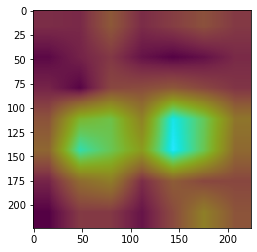

In [32]:
from matplotlib import pyplot as plt
plt.imshow(heatmap, interpolation='nearest')
plt.show()

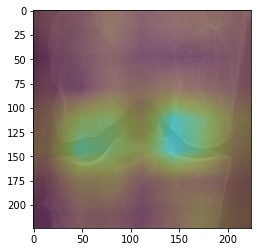

In [33]:
plt.imshow(output, interpolation='nearest')
plt.show()